<a href="https://colab.research.google.com/github/dmainagithub/Machine_Learning/blob/main/Catboost_exercise_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [3]:
# !pip install catboost

In [33]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Import data

In [5]:
df = pd.read_csv('/content/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Data preparation

In [7]:
df.dropna(subset=['Survived'],inplace=True)

In [9]:
df.shape

(891, 12)

In [11]:
# we are only going to use a few features ('pclass','sex', 'age', 'fare')
X = df[['Pclass','Sex', 'Age', 'Fare']]
y = df['Survived']

In [15]:
X['Pclass'] = X['Pclass'].astype('str')
X['Fare'].fillna(0,inplace=True)
X['Age'].fillna(0,inplace=True)

<ipython-input-15-249cbbabcdec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Pclass'] = X['Pclass'].astype('str')
<ipython-input-15-249cbbabcdec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Fare'].fillna(0,inplace=True)
<ipython-input-15-249cbbabcdec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'].fillna(0,inplace=True)


### Preparing Categorical Features

In [17]:
# A function that takes a dataframe and returns indices of all non-numeric columns as a list
def get_categorical_indicies(X):
  cats = []
  for col in X.columns:
    if is_numeric_dtype(X[col]):
      pass
    else:
      cats.append(col)
  cat_indicies = []
  for col in cats:
    cat_indicies.append(X.columns.get_loc(col))
  return cat_indicies

categorical_indicies = get_categorical_indicies(X)

In [19]:
# A function that identifies non-numerical columns and convert them to the category data type
def convert_cats(X):
  cats = []
  for col in X.columns:
    if is_numeric_dtype(X[col]):
      pass
    else:
      cats.append(col)
  cat_indicies = []
  for col in cats:
    X[col] = X[col].astype('category')

convert_cats(X)

<ipython-input-19-d41238f0b3fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


In [21]:
# split our data into two datasets for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [22]:
# Check whether there is class imbalance
print('Test Survival Rate:',y_test.sum()/y_test.count())

Test Survival Rate: 0.3854748603351955


In [24]:
# How we deal with class imbalance
train_df = pd.concat([X,y],axis=1)
survived = train_df[train_df['Survived']==1]
deceased = train_df[train_df['Survived']==0]
deceased = deceased.sample(n=len(survived), random_state=101)
train_df = pd.concat([survived,deceased],axis=0)
X_train = train_df.drop('Survived',axis=1)
y_train = train_df['Survived']

In [25]:
# Training (Catboost pool)
train_dataset = cb.Pool(X_train,y_train, cat_features=categorical_indicies)
test_dataset = cb.Pool(X_test,y_test, cat_features=categorical_indicies)

In [26]:
model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')

### Hyperparameters tuning

In [27]:
# dictionary of the hyperparameters
grid = {'learning_rate': [0.03, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100, 150]}

In [28]:
model.grid_search(grid,train_dataset)

Streaming output truncated to the last 5000 lines.
86:	learn: 0.8062157	test: 0.7445255	best: 0.7810219 (1)	total: 194ms	remaining: 29ms
87:	learn: 0.8062157	test: 0.7299270	best: 0.7810219 (1)	total: 196ms	remaining: 26.7ms
88:	learn: 0.8043876	test: 0.7299270	best: 0.7810219 (1)	total: 198ms	remaining: 24.4ms
89:	learn: 0.8025594	test: 0.7299270	best: 0.7810219 (1)	total: 200ms	remaining: 22.2ms
90:	learn: 0.8043876	test: 0.7299270	best: 0.7810219 (1)	total: 202ms	remaining: 20ms
91:	learn: 0.8025594	test: 0.7299270	best: 0.7810219 (1)	total: 204ms	remaining: 17.8ms
92:	learn: 0.8025594	test: 0.7445255	best: 0.7810219 (1)	total: 206ms	remaining: 15.5ms
93:	learn: 0.8007313	test: 0.7445255	best: 0.7810219 (1)	total: 209ms	remaining: 13.3ms
94:	learn: 0.8007313	test: 0.7445255	best: 0.7810219 (1)	total: 211ms	remaining: 11.1ms
95:	learn: 0.8062157	test: 0.7299270	best: 0.7810219 (1)	total: 213ms	remaining: 8.86ms
96:	learn: 0.8062157	test: 0.7299270	best: 0.7810219 (1)	total: 215ms	rem

{'params': {'depth': 10,
  'learning_rate': 0.03,
  'l2_leaf_reg': 1,
  'iterations': 50},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [30]:
# The model is now trained
# print out the optimum parameters
model.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 10,
 'learning_rate': 0.03,
 'l2_leaf_reg': 1,
 'iterations': 50}

### Model evaluation

In [31]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       110
           1       0.76      0.57      0.65        69

    accuracy                           0.77       179
   macro avg       0.77      0.73      0.74       179
weighted avg       0.77      0.77      0.76       179



### Analyse impact our features

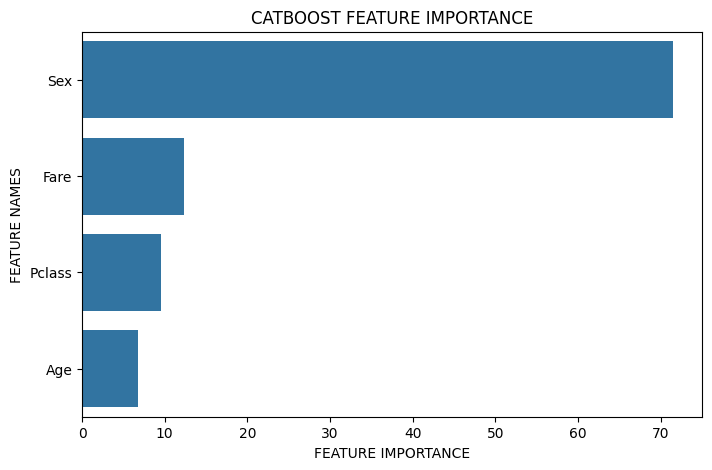

In [37]:
# Function to help plot feature importance
def plot_feature_importance(importance, names, model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(8,5))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(), X_train.columns,'CATBOOST')

In [ ]:
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a


Pclass
3    491
1    216
2    184
Name: count, dtype: int64

### Resources
1. https://www.analyseup.com/python-machine-learning/catboost-python-tutorial.html
2. https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
